<a href="https://colab.research.google.com/github/ekotyoo/Racana/blob/Machine_Learning/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

from tensorflow import keras
from collections import deque
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_squared_error



In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Preparing Data Set
memasukan data tempat wisata

In [4]:
link = 'https://drive.google.com/file/d/1Fjjh_nSMWssHE4Ncv7aURngnN5wsfJ_y/view'


# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tourism_with_id.csv')

place = pd.read_csv('tourism_with_id.csv')
print(place)


    Place_Id                     Place_Name  \
0          1              Agrowisata Satria   
1          2                     Agung Bali   
2          3  Wisata Air Panas Toya Bungkah   
3          4         Air Terjun Aling-Aling   
4          5          Air Terjun Tegenungan   
..       ...                            ...   
70        71         Teras Sawah Tegalalang   
71        72                   Tirta Gangga   
72        73                  Waterbom Bali   
73        74       Alas Harum Agro Tourism    
74        75     Wisata Agro Teba Sari Bali   

                                          Description  Weekend Holiday Price  \
0   Agrowisata Satria menawarkan 'rasa' Bali pada ...                  50000   
1   Dapatkan berbagai produk oleh-oleh khas Bali b...                      0   
2   Pemandian air panas di dekat gunung Batur (Pem...                  70000   
3   Keberadaan air terjun ini semakin mempercantik...                  20000   
4   Bosan dengan wisata alam pantai

In [5]:
# Melihat gambaran data place

place.head()

,Place_Id,Place_Name,Description,Weekend Holiday Price,Weekday Price,Category,City,Rating,Alamat,Coordinate,Lat,Long,Gambar
0,1,Agrowisata Satria,Agrowisata Satria menawarkan 'rasa' Bali pada ...,50000,50000,Agrowisata,Gianyar,3.0,"Manukaya, Kec. Tampaksiring, Kabupaten Gianya...","-8.402228546131536, 115.32296693687739",-8.402229,115.322967,V
1,2,Agung Bali,Dapatkan berbagai produk oleh-oleh khas Bali b...,0,0,Belanja,Badung,4.0,"Jln. Dewi Sri No.18XX, Kuta, Badung, Bali","-8.700234336021559, 115.176534407375",-8.700234,115.176534,V
2,3,Wisata Air Panas Toya Bungkah,Pemandian air panas di dekat gunung Batur (Pem...,70000,70000,Alam,Bangli,4.0,"Batur Tengah, Kec. Kintamani, Kabupaten Bangli...","-8.251298580809106, 115.39981444195475",-8.251299,115.399814,V
3,4,Air Terjun Aling-Aling,Keberadaan air terjun ini semakin mempercantik...,20000,20000,Alam,Buleleng,4.5,"Jl. Raya Desa Sambangan, Banjar, Sambangan, Ke...","-8.173073590748519, 115.10513024047802",-8.173074,115.105130,V
4,5,Air Terjun Tegenungan,Bosan dengan wisata alam pantai dan ingin meni...,20000,20000,Alam,Gianyar,4.0,"Jl. Ir. Sutami, Kemenuh, Kec. Sukawati, Kabupa...","-8.575191460385602, 115.28870189592831",-8.575191,115.288702,V


In [6]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Place_Id               75 non-null     int64  
 1   Place_Name             75 non-null     object 
 2   Description            75 non-null     object 
 3   Weekend Holiday Price  75 non-null     int64  
 4   Weekday Price          75 non-null     int64  
 5   Category               75 non-null     object 
 6   City                   75 non-null     object 
 7   Rating                 75 non-null     float64
 8   Alamat                 75 non-null     object 
 9   Coordinate             75 non-null     object 
 10  Lat                    75 non-null     float64
 11  Long                   75 non-null     float64
 12  Gambar                 75 non-null     object 
dtypes: float64(3), int64(3), object(7)
memory usage: 7.7+ KB


Memasukkan data rating

In [7]:
rate =  'https://drive.google.com/file/d/1O8nHRBufcBe26vB8GHicaTTqAlIcUv8E/view'

# to get the id part of the file
id = rate.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tourism_rating.csv')

rating = pd.read_csv('tourism_rating.csv')
rating.head()

,User_Id,Place_Id,Nama Tempat,Place_Rating
0,1,2,Agung Bali Oleh-Oleh,3
1,1,7,Aloha Ubud Swing,5
2,1,8,Bali Bird Park,5
3,1,12,Big Garden Corner,2
4,1,13,Wanagiri Hidden Hills,5


In [8]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_Id       3000 non-null   int64 
 1   Place_Id      3000 non-null   int64 
 2   Nama Tempat   3000 non-null   object
 3   Place_Rating  3000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 93.9+ KB


Filtering data rating

In [9]:
min_place_rating = 10
filter_place = (rating["Place_Id"].value_counts()>min_place_rating)
filter_place = filter_place[filter_place].index.tolist()

min_user_rating = 10
filter_user = (rating["User_Id"].value_counts()>min_user_rating)
filter_user = filter_user[filter_user].index.tolist()

data_filtered = rating[(rating["Place_Id"].isin(filter_place)) & 
                       (rating["User_Id"].isin(filter_place))]
del filter_place,filter_user,min_place_rating,min_user_rating
print('Shape User-Ratings unfiltered:\t{}'.format(rating.shape))
print('Shape User-Ratings filtered:\t{}'.format(data_filtered.shape))

Shape User-Ratings unfiltered:	(3000, 4)
Shape User-Ratings filtered:	(2250, 4)


Membagi data set menjadi train dan test

In [12]:
data_filtered = data_filtered.sample(frac=1).reset_index(drop=True)

n =500

df_train = data_filtered[:-n]
df_test = data_filtered[-n:]

#Deep Learning With Keras
With its embedding layers this is similar to the matrix factorization approach above, but instead of using a fixed dot-product as recommendation we will utilize some dense layers so the network can find better combinations.

In [13]:
# Mapping user dan place id
user_mapping = {id:i for i, id in enumerate(data_filtered['User_Id'].unique())}
place_mapping = {id:i for i, id in enumerate(data_filtered['Place_Id'].unique())}


# Membagi data berdasarkan mapping
train_user = df_train['User_Id'].map(user_mapping)
train_place = df_train['Place_Id'].map(place_mapping)

test_user = df_test['User_Id'].map(user_mapping)
test_place = df_test['Place_Id'].map(place_mapping)

# Atur Variabel
user_embedding_size = 20
place_embedding_size = 10

# Masukin parameter
users = len(user_mapping)
places = len(place_mapping)
embedding_size = 10


Mulai Pembuatan Model

In [14]:


#Mengatur input layer
user_id_input = Input(shape=[1], name='user')
place_id_input = Input(shape=[1], name='place')

# Membuat Embedding layer
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
place_embedding = Embedding(output_dim=place_embedding_size, 
                            input_dim=places,
                            input_length=1, 
                            name='item_embedding')(place_id_input)

# Reshape embedding layers yang sudah dibuat
user_vector = Reshape([user_embedding_size])(user_embedding)
place_vector = Reshape([place_embedding_size])(place_embedding)

# Di concate supaya bisa jadi 1 list
concat = Concatenate()([user_vector, place_vector])

# masukin dense layer
fc1 = Dense(64, activation='relu')(concat)
y = Dense(1)(fc1)



In [ ]:
user_id_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'user')>

In [15]:
# Setup model yang sudah dibuat
model = Model(inputs=[user_id_input, place_id_input], outputs=y)
model.compile(
    loss = "mse",optimizer ="adam",metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Hasil fit model
history = model.fit([train_user, train_place],
          df_train['Place_Rating'],
          batch_size=256, 
          epochs=100,
          validation_split=0.1,
          shuffle=True)


Epoch 1/100
7/7 [==============================] - 1s 35ms/step - loss: 17.8476 - root_mean_squared_error: 4.2246 - val_loss: 17.7738 - val_root_mean_squared_error: 4.2159
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 17.2651 - root_mean_squared_error: 4.1551 - val_loss: 17.1420 - val_root_mean_squared_error: 4.1403
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 16.6014 - root_mean_squared_error: 4.0745 - val_loss: 16.3673 - val_root_mean_squared_error: 4.0457
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 15.7696 - root_mean_squared_error: 3.9711 - val_loss: 15.3759 - val_root_mean_squared_error: 3.9212
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 14.7010 - root_mean_squared_error: 3.8342 - val_loss: 14.1261 - val_root_mean_squared_error: 3.7585
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 13.3612 - root_mean_squared_error: 3.6553 - val_loss: 12.6002 - val_root_

In [16]:
pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://d3bb3a92-e567-440f-a691-0904dc3bf211/assets


In [17]:
with open('model.pkl', 'rb') as pickle_in:
     unpickled_mercury = pickle.load(pickle_in)

In [18]:
print("Name: ", unpickled_mercury.name)
print("Size: ", unpickled_mercury.size)

Name:  model


AttributeError: ignored

Mencoba Model 

In [19]:
# Test model
y_pred = model.predict([test_user, test_place])
y_true = df_test['Place_Rating'].values

In [21]:
#  Evaluasi dengan RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))



Testing Result With Keras Deep Learning: 1.0082 RMSE


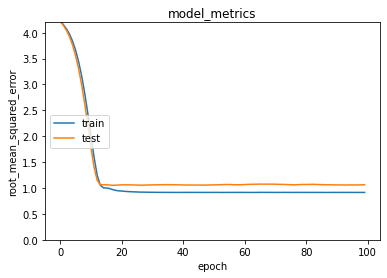

In [22]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=4.2)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Mulai Testing dan Predicting 

In [23]:
# Menyiapkan dataframe
place_df = place[['Place_Id','Place_Name','Category','Rating','Weekend Holiday Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()


In [24]:
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [25]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [26]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [27]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [28]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
 
# Mengubah rating menjadi nilai float
df['Place_Rating'] = df['Place_Rating'].values.astype(np.float32)
 
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Rating']), max(df['Place_Rating'])
 
print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 100, Number of Place: 75, Min Rating: 1.0, Max Rating: 5.0


In [29]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [30]:
user_place_array

array([[53,  0],
       [53,  2],
       [53, 48],
       [53, 33],
       [53, 34],
       [53,  3],
       [53,  4],
       [53, 49],
       [53, 58],
       [53, 35],
       [53, 51],
       [53, 64],
       [53, 36],
       [53,  7],
       [53, 69],
       [53, 59],
       [53, 70],
       [53, 37],
       [53,  8],
       [53,  9],
       [53, 10],
       [53, 12],
       [53, 13],
       [53, 14],
       [53, 16],
       [53, 60],
       [53, 17],
       [53, 53],
       [53, 19],
       [53, 20],
       [53, 22],
       [53, 23],
       [53, 61],
       [53, 54],
       [53, 41],
       [53, 26],
       [53, 55],
       [53, 73],
       [53, 74],
       [53, 62],
       [53, 63],
       [53, 28],
       [53, 29],
       [53, 43],
       [53, 57]])

In [31]:
class DeepRecommender(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(DeepRecommender, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.places_bias = Embedding(num_places, 1) # layer embedding places bias
    self.dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # memanggil layer embedding 3
    places_bias = self.places_bias(inputs[:, 1]) # memanggil layer embedding 4
    dot_user_places = tf.tensordot(user_vector, places_vector, 2) 
    x = dot_user_places + user_bias + places_bias
    y = self.dense1(x)
    return self.dense2(y)


In [32]:
model = DeepRecommender(num_users, num_place, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [41]:
model.save_weights('saved_model.h5', save_format='hdf5')

In [ ]:
# Mengambil top rekomendasi
ratings = model.predict(user_place_array,50).flatten()
top_ratings_indices = ratings.argsort()[:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
recommended_place_ids = list(recommended_place_ids)
print(recommended_place_ids)


In [ ]:
#Membuat Filter
Place_Upto_100 = place_df[(place_df['price'] >= 100000)]
Place_Upto_100 = list(Place_Upto_100["id"])
print(Place_Upto_100)

In [ ]:
#Filtering place up to 100k
recom_id_upto_100 = [x for x in recommended_place_ids if x in Place_Upto_100]
print(recom_id_upto_100)

In [ ]:
#Filtering place up to 100k
recom_id_under_100 = [x for x in recommended_place_ids if x not in Place_Upto_100]
print(recom_id_under_100)

In [ ]:
print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)
 
top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Rating',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Harga Tiket Masuk ', row.price, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)